# Load data

This notebook will apply EOF analysis to regridded V20 SSH data via a Jupyter Notebook using ferretmagic.  Many thanks to Patrick Brockmann and the [ferretmagic documentation](https://github.com/PBrockmann/C-CASCADES_notebooks/blob/master/ferretBasics.ipynb) for providing an excellent starting point!  Also thanks to the Ferret Development Team for their [EOF example](https://ferret.pmel.noaa.gov/Ferret/documentation/ferret-eof-demo).  More details on the EOFSVD code are [here](https://ferret.pmel.noaa.gov/Ferret/documentation/users-guide/appendix-a-external-functions/EOF-SPACE#_eofsvd_space).  First we start ferretmagic and then load the data into PyFerret.

In [1]:
%load_ext ferretmagic

In [2]:
%%ferret

cancel data/all
!use /home/jovyan/data/1_mesh_mask.nc
!use /home/jovyan/data/V20_1948_2009_SSH.nc
!use coads_climatology
use V20_1958_2009_SSH_regridded.nc
set memory /size=2000
show data


currently SET data sets:
 1> ./V20_1958_2009_SSH_regridded.nc (default)
 name title I J K L
 TIME ... ... ... 1:24
 (invalid coordinate axis)
 SSH 1:89 1:85 ... 1:24
 GLAMT 1:89 1:85 ... ...
 GPHIT 1:89 1:85 ... ...

# Sample plot of data

! Enter_GO land
! Exit_GO


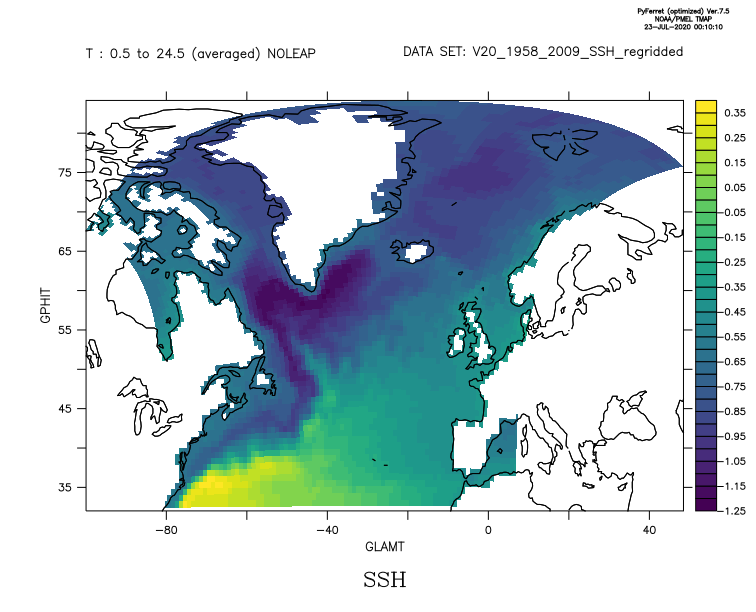

In [3]:
%%ferret
shade /i=2:2000 /j=2:2000 ssh[l=@AVE],glamt,gphit; go land

# Run EOF

In [4]:
%%ferret
let eof_time = eofsvd_tfunc(ssh[d=1])
save /clobber /file=eof_time.nc eof_time


In [5]:
%%ferret
let eof_space = eofsvd_space(ssh[d=1])
save /clobber /file=eof_space.nc eof_space


In [6]:
%%ferret
let eof_stat = eofsvd_stat(ssh[d=1])
save /clobber /file=eof_stat.nc eof_stat


In [7]:
%%ferret
use eof_time.nc
use eof_space.nc
use eof_stat.nc
sh d

currently SET data sets:
 1> ./V20_1958_2009_SSH_regridded.nc
 name title I J K L
 TIME ... ... ... 1:24
 (invalid coordinate axis)
 SSH 1:89 1:85 ... 1:24
 GLAMT 1:89 1:85 ... ...
 GPHIT 1:89 1:85 ... ...
 
 2> ./eof_time.nc
 name title I J K L
 TIME ... ... ... 1:24
 (invalid coordinate axis)
 EOF_TIME EOFSVD_TFUNC(SSH[D=1]) 1:7565 ... ... 1:24
 
 3> ./eof_space.nc
 name title I J K L
 EOF_SPACE
 EOFSVD_SPACE(SSH[D=1]) 1:89 1:85 ... 1:7565
 
 4> ./eof_stat.nc (default)
 name title I J K L
 EOF_STAT EOFSVD_STAT(SSH[D=1]) 1:7565 1:3 ... ...

In [8]:
%%ferret
! List the number of EOFs
list eof_stat[d=4,i=1,j=1]


VARIABLE : EOFSVD_STAT(SSH[D=V20_1958_2009_SSH_regridded])
 X : 1
 Y : 1
 7565.


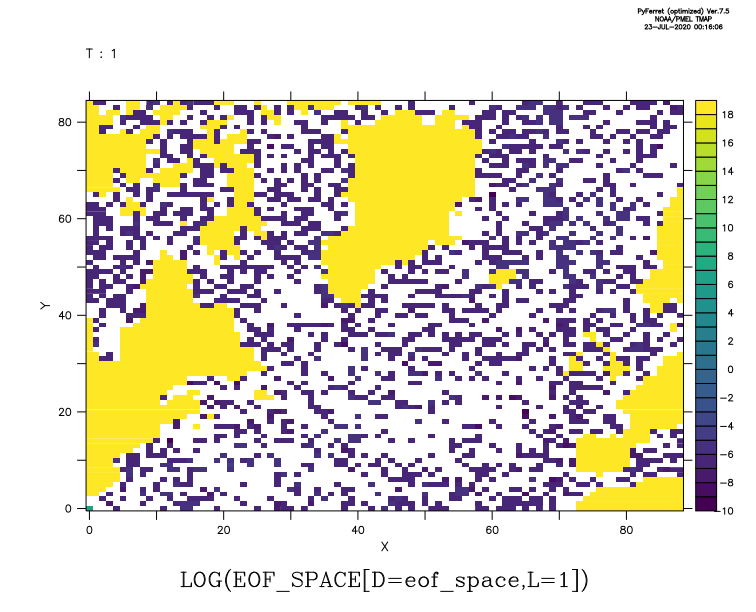

In [23]:
%%ferret
shade log(eof_space[d=3,l=1])

# Copied lines from the Ferret development team's demo to verify output

! Enter_GO land
! Exit_GO
! Enter_GO land
! Exit_GO
! Enter_GO land
! Exit_GO


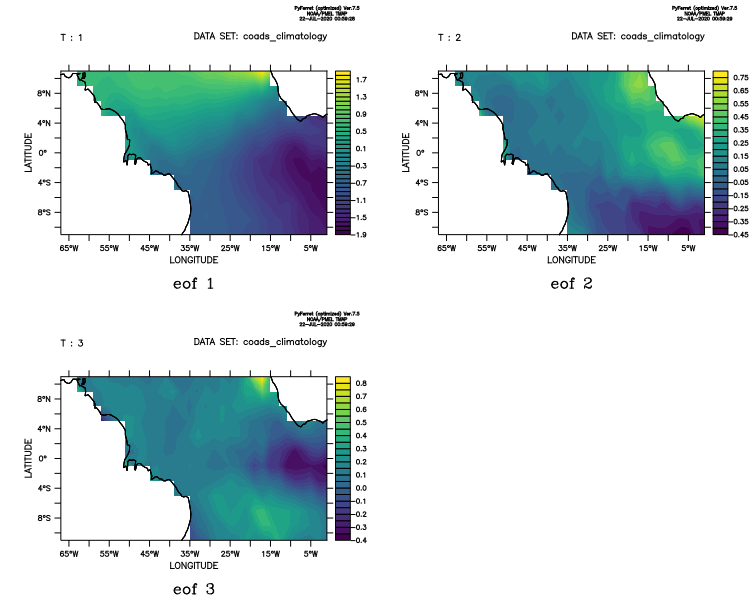

In [3]:
%%ferret
let eof_xyfcn = eofsvd_space(sst[X=67w:1w,Y=11S:11N])

set view ul; fill/l=1/TITLE="eof 1" eof_xyfcn; go land
set view ur; fill/l=2/TITLE="eof 2" eof_xyfcn; go land
set view ll; fill/l=3/TITLE="eof 3" eof_xyfcn; go land



In [4]:
%%ferret
LET eofstat = EOFSVD_STAT(sst[X=67w:1w,Y=11S:11N])
list eofstat[j=2]

VARIABLE : EOFSVD_STAT(SST[X=67W:1W,Y=11S:11N])
 FILENAME : coads_climatology.cdf
 FILEPATH : /opt/conda/envs/pyferret/share/fer_dsets/data/
 SUBSET : 408 points (X)
 Y : 2
 2 
 2
 1 / 1: 86.95
 2 / 2: 5.82
 3 / 3: 3.87
 4 / 4: 1.51
 5 / 5: 0.56
 6 / 6: 0.38
 7 / 7: 0.31
 8 / 8: 0.23
 9 / 9: 0.15
 10 / 10: 0.11
 11 / 11: 0.10
 12 / 12: 0.00
 13 / 13: 0.00
 14 / 14: 0.00
 15 / 15: 0.00
 16 / 16: 0.00
 17 / 17: 0.00
 18 / 18: 0.00
 19 / 19: 0.00
 20 / 20: 0.00
 21 / 21: 0.00
 22 / 22: 0.00
 23 / 23: 0.00
 24 / 24: 0.00
 25 / 25: 0.00
 26 / 26: 0.00
 27 / 27: 0.00
 28 / 28: 0.00
 29 / 29: 0.00
 30 / 30: 0.00
 31 / 31: 0.00
 32 / 32: 0.00
 33 / 33: 0.00
 34 / 34: 0.00
 35 / 35: 0.00
 36 / 36: 0.00
 37 / 37: 0.00
 38 / 38: 0.00
 39 / 39: 0.00
 40 / 40: 0.00
 41 / 41: 0.00
 42 / 42: 0.00
 43 / 43: 0.00
 44 / 44: 0.00
 45 / 45: 0.00
 46 / 46: 0.00
 47 / 47: 0.00
 48 / 48: 0.00
 49 / 49: 0.00
 50 / 50: 0.00
 51 / 51: 0.00
 52 / 52: 0.00
 53 / 53: 0.00
 54 / 54: 0.00
 55 / 55: 0.00
 56 / 56: 0.00
 57 / 57: 0.00
 58 / 58: 0.00
 59 / 59: 0.00
 60 / 60: 0.00
 61 / 61: 0.00
 62 / 62: 0.00
 63 / 63: 0.00
 64 / 64: 0.00
 65 / 65: 0.00
 66 / 66: 0.00
 67 / 67: 0.00
 68 / 68: 0.00
 69 / 69: 0.00
 70 / 70: 0.00
 71 / 71: 0.00
 72 / 72: 0.00
 73 / 73: 0.00
 74 / 74: 0.00
 75 / 75: 0.00
 76 / 76: 0.00
 77 / 77: 0.00
 78 / 78: 0.00
 79 / 79: 0.00
 80 / 80: 0.00
 81 / 81: 0.00
 82 / 82: 0.00
 83 / 83: 0.00
 84 / 84: 0.00
 85 / 85: 0.00
 86 / 86: 0.00
 87 / 87: 0.00
 88 / 88: 0.00
 89 / 89: 0.00
 90 / 90: 0.00
 91 / 91: 0.00
 92 / 92: 0.00
 93 / 93: 0.00
 94 / 94: 0.00
 95 / 95: 0.00
 96 / 96: 0.00
 97 / 97: 0.00
 98 / 98: 0.00
 99 / 99: 0.00
 100 / 100: 0.00
 101 / 101: 0.00
 102 / 102: 0.00
 103 / 103: 0.00
 104 / 104: 0.00
 105 / 105: 0.00
 106 / 106: 0.00
 107 / 107: 0.00
 108 / 108: 0.00
 109 / 109: 0.00
 110 / 110: 0.00
 111 / 111: 0.00
 112 / 112: 0.00
 113 / 113: 0.00
 114 / 114: 0.00
 115 / 115: 0.00
 116 / 116: 0.00
 117 / 117: 0.00
 118 / 118: 0.00
 119 / 119: 0.00
 120 / 120: 0.00
 121 / 121: 0.00
 122 / 122: 0.00
 123 / 123: 0.00
 124 / 124: 0.00
 125 / 125: 0.00
 126 / 126: 0.00
 127 / 127: 0.00
 128 / 128: 0.00
 129 / 129: 0.00
 130 / 130: 0.00
 131 / 131: 0.00
 132 / 132: 0.00
 133 / 133: 0.00
 134 / 134: 0.00
 135 / 135: 0.00
 136 / 136: 0.00
 137 / 137: 0.00
 138 / 138: 0.00
 139 / 139: 0.00
 140 / 140: 0.00
 141 / 141: 0.00
 142 / 142: 0.00
 143 / 143: 0.00
 144 / 144: 0.00
 145 / 145: 0.00
 146 / 146: 0.00
 147 / 147: 0.00
 148 / 148: 0.00
 149 / 149: 0.00
 150 / 150: 0.00
 151 / 151: 0.00
 152 / 152: 0.00
 153 / 153: 0.00
 154 / 154: 0.00
 155 / 155: 0.00
 156 / 156: 0.00
 157 / 157: 0.00
 158 / 158: 0.00
 159 / 159: 0.00
 160 / 160: 0.00
 161 / 161: 0.00
 162 / 162: 0.00
 163 / 163: 0.00
 164 / 164: 0.00
 165 / 165: 0.00
 166 / 166: 0.00
 167 / 167: 0.00
 168 / 168: 0.00
 169 / 169: 0.00
 170 / 170: 0.00
 171 / 171: 0.00
 172 / 172: 0.00
 173 / 173: 0.00
 174 / 174: 0.00
 175 / 175: 0.00
 176 / 176: 0.00
 177 / 177: 0.00
 178 / 178: 0.00
 179 / 179: 0.00
 180 / 180: 0.00
 181 / 181: 0.00
 182 / 182: 0.00
 183 / 183: 0.00
 184 / 184: 0.00
 185 / 185: 0.00
 186 / 186: 0.00
 187 / 187: 0.00
 188 / 188: 0.00
 189 / 189: 0.00
 190 / 190: 0.00
 191 / 191: 0.00
 192 / 192: 0.00
 193 / 193: 0.00
 194 / 194: 0.00
 195 / 195: 0.00
 196 / 196: 0.00
 197 / 197: 0.00
 198 / 198: 0.00
 199 / 199: 0.00
 200 / 200: 0.00
 201 / 201: 0.00
 202 / 202: 0.00
 203 / 203: 0.00
 204 / 204: 0.00
 205 / 205: 0.00
 206 / 206: 0.00
 207 / 207: 0.00
 208 / 208: 0.00
 209 / 209: 0.00
 210 / 210: 0.00
 211 / 211: 0.00
 212 / 212: 0.00
 213 / 213: 0.00
 214 / 214: 0.00
 215 / 215: 0.00
 216 / 216: 0.00
 217 / 217: 0.00
 218 / 218: 0.00
 219 / 219: 0.00
 220 / 220: 0.00
 221 / 221: 0.00
 222 / 222: 0.00
 223 / 223: 0.00
 224 / 224: 0.00
 225 / 225: 0.00
 226 / 226: 0.00
 227 / 227: 0.00
 228 / 228: 0.00
 229 / 229: 0.00
 230 / 230: 0.00
 231 / 231: 0.00
 232 / 232: 0.00
 233 / 233: 0.00
 234 / 234: 0.00
 235 / 235: 0.00
 236 / 236: 0.00
 237 / 237: 0.00
 238 /